# MCM-C题——特征贡献度
## 基于平均不纯度减少（MDI）的特征重要性分析
在机器学习领域，理解特征对于模型预测结果的贡献程度至关重要。特征重要性分析不仅能够帮助我们筛选出关键特征，提升模型的性能和可解释性，还能让我们深入洞察数据背后的潜在规律。本研究采用基于平均不纯度减少（Mean Decrease Impurity，MDI）的方法，利用LightGBM模型对不同聚类数据集中的特征重要性进行评估。

## 数据集
研究使用了多个数据集，包括**总数据集**以及**Cluster0、Cluster1、Cluster2、Cluster3数据集**。

## 数据预处理
为了确保模型训练的稳定性和有效性，对数据进行了最大最小归一化处理。最大最小归一化通过将数据映射到[0, 1]区间，消除了不同特征之间量纲的影响，使得模型能够更好地学习特征与目标变量之间的关系。归一化公式如下：
\[
X_{norm}=\frac{X - X_{min}}{X_{max}-X_{min}}
\]
其中，\(X_{norm}\)为归一化后的数据，\(X\)为原始数据，\(X_{min}\)和\(X_{max}\)分别为原始数据中的最小值和最大值。

## LightGBM模型
本研究选用LightGBM作为建模工具。LightGBM是一种基于梯度提升决策树（GBDT）的高效机器学习框架，它在处理大规模数据时具有计算速度快、内存占用少等优势。其核心思想是通过迭代训练一系列决策树，逐步减少预测结果与真实值之间的误差。

LightGBM模型的目标函数定义为：
\[
Obj(\phi)=\sum_{i = 1}^{n}l(y_{i},\hat{y}_{i})+\sum_{k = 1}^{K}\Omega(f_{k})
\]
其中，\(\phi\)表示整个模型，\(l(y_{i},\hat{y}_{i})\)为第\(i\)个样本的损失函数，衡量预测值\(\hat{y}_{i}\)与真实值\(y_{i}\)之间的差异；\(\Omega(f_{k})\)为第\(k\)棵树的复杂度正则化项，用于防止模型过拟合；\(n\)为样本数量，\(K\)为树的数量。

在本研究中，使用了多分类目标函数`objective='multiclass'`，并以多分类对数损失`metric='multi_logloss'`作为评估指标，其公式为：
\[
L_{multi - logloss}=-\frac{1}{N}\sum_{i = 1}^{N}\sum_{j = 1}^{C}y_{ij}\log(\hat{y}_{ij})
\]
其中，\(N\)为样本总数，\(C\)为类别数，\(y_{ij}\)表示第\(i\)个样本属于第\(j\)类的真实标签（0或1），\(\hat{y}_{ij}\)表示模型预测第\(i\)个样本属于第\(j\)类的概率。

## 平均不纯度减少（MDI）原理
MDI是一种衡量特征重要性的常用方法，其核心思想基于决策树的分裂准则。在决策树构建过程中，每个节点通过选择一个特征进行分裂，以降低数据集的不纯度。常用的不纯度度量指标有基尼系数（Gini Index）和信息熵（Entropy）。

以基尼系数为例，其计算公式为：
\[
Gini(p)=\sum_{i = 1}^{C}p_{i}(1 - p_{i}) = 1-\sum_{i = 1}^{C}p_{i}^{2}
\]
其中，\(p_{i}\)表示属于第\(i\)类样本的比例，\(C\)为类别数。基尼系数衡量了从数据集中随机抽取两个样本，其类别标记不一致的概率，值越小表示数据集越“纯净”。

当一个特征被用于分裂节点时，会计算分裂前后数据集的基尼系数变化，即平均不纯度减少量。特征的重要性得分就是该特征在所有决策树中引起的平均不纯度减少量的总和。假设某个特征\(f\)在第\(t\)棵树的第\(j\)个节点上进行分裂，分裂前节点的基尼系数为\(Gini_{parent}\)，分裂后左右子节点的基尼系数分别为\(Gini_{left}\)和\(Gini_{right}\)，样本权重分别为\(w_{left}\)和\(w_{right}\)，则该特征在该节点上引起的不纯度减少量为：
\[
\Delta Gini = Gini_{parent}-(w_{left}Gini_{left}+w_{right}Gini_{right})
\]
特征\(f\)的重要性得分\(I(f)\)为：
\[
I(f)=\sum_{t = 1}^{T}\sum_{j\in nodes_{t}(f)}\Delta Gini_{t,j}
\]
其中，\(T\)为决策树的总数，\(nodes_{t}(f)\)表示第\(t\)棵树中使用特征\(f\)进行分裂的节点集合。

## 模型训练与评估
LightGBM的参数为寻优的最佳参数
***
## 一、全部数据集分析

In [1]:
## 基于平均不纯度减少（Mean Decrease Impurity，MDI）的方法

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(font_scale=1)
pd.set_option('display.max_columns', 0) # 显示所有列
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

## All Cluster
# 导入数据
data = pd.read_csv("Data_all_Cluster.csv",index_col=0)
print(data.head())

# 定义输入特征和输出目标
features = ['Opponent_Team_Avg_Medals', 'Team_Medal_Count', 'Country_Medal_Count',
            'Country_Sport_Medal_Count', 'No medal', 'Score', 'Gold',
            'Sport_Competition_Level', 'Yearly_Event_Participant_Count',
            'Opponent_Total_Medals', 'Coach']

target = 'Medal'

X = data[features]
y = data[target]

# 最大最小归一化
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

## LightGBM
model = lgb.LGBMClassifier(learning_rate=0.1, min_child_samples=50, n_estimators=150, 
                               num_leaves=50, objective='multiclass', metric='multi_logloss', random_state=0)
model.fit(X, y)

# 模型评估
y_pred = model.predict(X)
accuracy = accuracy_score(y, y_pred)
print('Accuracy: %.2f' % accuracy)

# 获取特征重要性
importances = model.feature_importances_

# 打印特征重要性
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df

          Coach  Team_Medal_Count  ...  Unnamed: 17  Score.1
编号                                 ...                      
1    968.352113              1140  ...          NaN      NaN
2    419.945946              1140  ...          NaN      NaN
3    761.768421               622  ...          NaN      NaN
4      8.000000                 6  ...          NaN      NaN
5   1691.800000              1056  ...          NaN      NaN

[5 rows x 18 columns]
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004087 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 988
[LightGBM] [Info] Number of data points in the train set: 252565, number of used features: 11
[LightGBM] [Info] Start training from score -0.166876
[LightGBM] [Info] Start training from score -2.961349
[LightGBM] [Info] Start training from score -2.986451
[LightGBM] [Info] Start training fr

,Feature,Importance
5,Score,5632
6,Gold,5055
10,Coach,4910
4,No medal,3921
1,Team_Medal_Count,3237
3,Country_Sport_Medal_Count,3037
7,Sport_Competition_Level,2912
0,Opponent_Team_Avg_Medals,360
2,Country_Medal_Count,195
8,Yearly_Event_Participant_Count,82


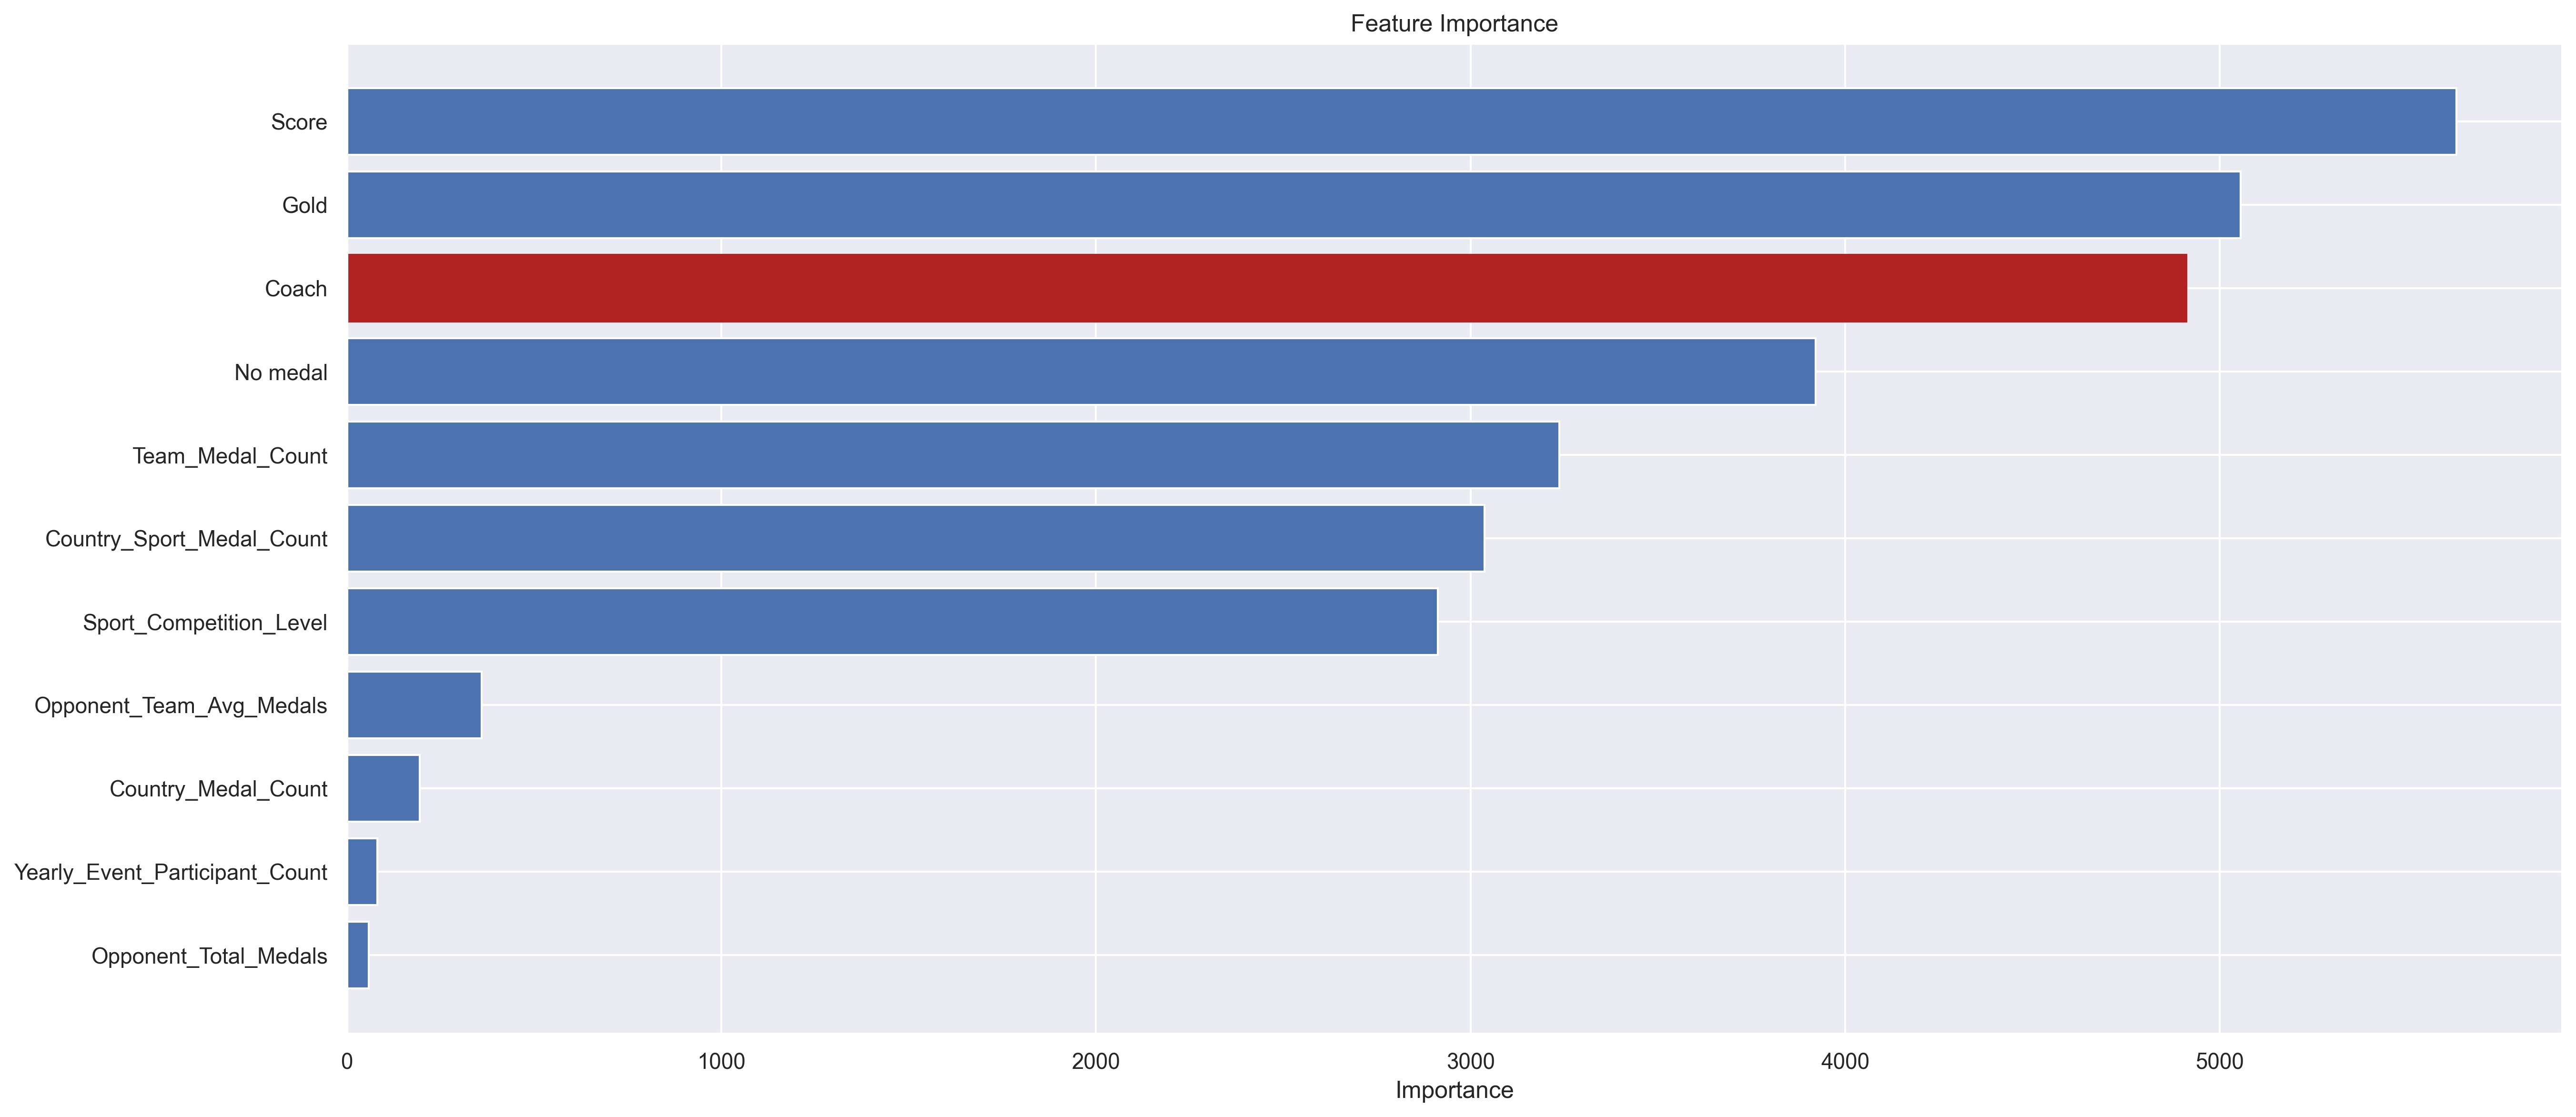

In [2]:
# 可视化特征重要性
plt.figure(figsize=(20, 9), dpi=300)
bars = plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
for bar, feature in zip(bars, feature_importance_df['Feature']):
    if feature == 'Coach':
        bar.set_color('firebrick')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis() 
plt.savefig('All Cluster 特征重要性.png')

## 二、Cluster0

In [3]:

## Cluster0
# 导入数据
data = pd.read_csv("cluster0.csv",index_col=0)
print(data.head())

X = data[features]
y = data[target]

## LightGBM
model = lgb.LGBMClassifier(learning_rate=0.1, min_child_samples=50, n_estimators=150, 
                               num_leaves=50, objective='multiclass', metric='multi_logloss', random_state=0)
model.fit(X, y)

# 获取特征重要性
importances = model.feature_importances_

# 打印特征重要性
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df

          Score  Team_Medal_Count  ...  Opponent_Total_Medals  Medal
编号                                 ...                              
5   1691.800000              1056  ...                      0      0
6   1956.500000              1056  ...                      0      0
39  1225.215686              1056  ...                      0      0
42  1517.790323              1056  ...                      0      1
43   978.210526              1056  ...                      0      2

[5 rows x 12 columns]
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000851 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 799
[LightGBM] [Info] Number of data points in the train set: 52506, number of used features: 10
[LightGBM] [Info] Start training from score -0.184129
[LightGB

,Feature,Importance
5,Score,6403
6,Gold,5326
10,Coach,4805
4,No medal,4193
3,Country_Sport_Medal_Count,3423
7,Sport_Competition_Level,2803
1,Team_Medal_Count,1686
0,Opponent_Team_Avg_Medals,403
2,Country_Medal_Count,272
8,Yearly_Event_Participant_Count,86


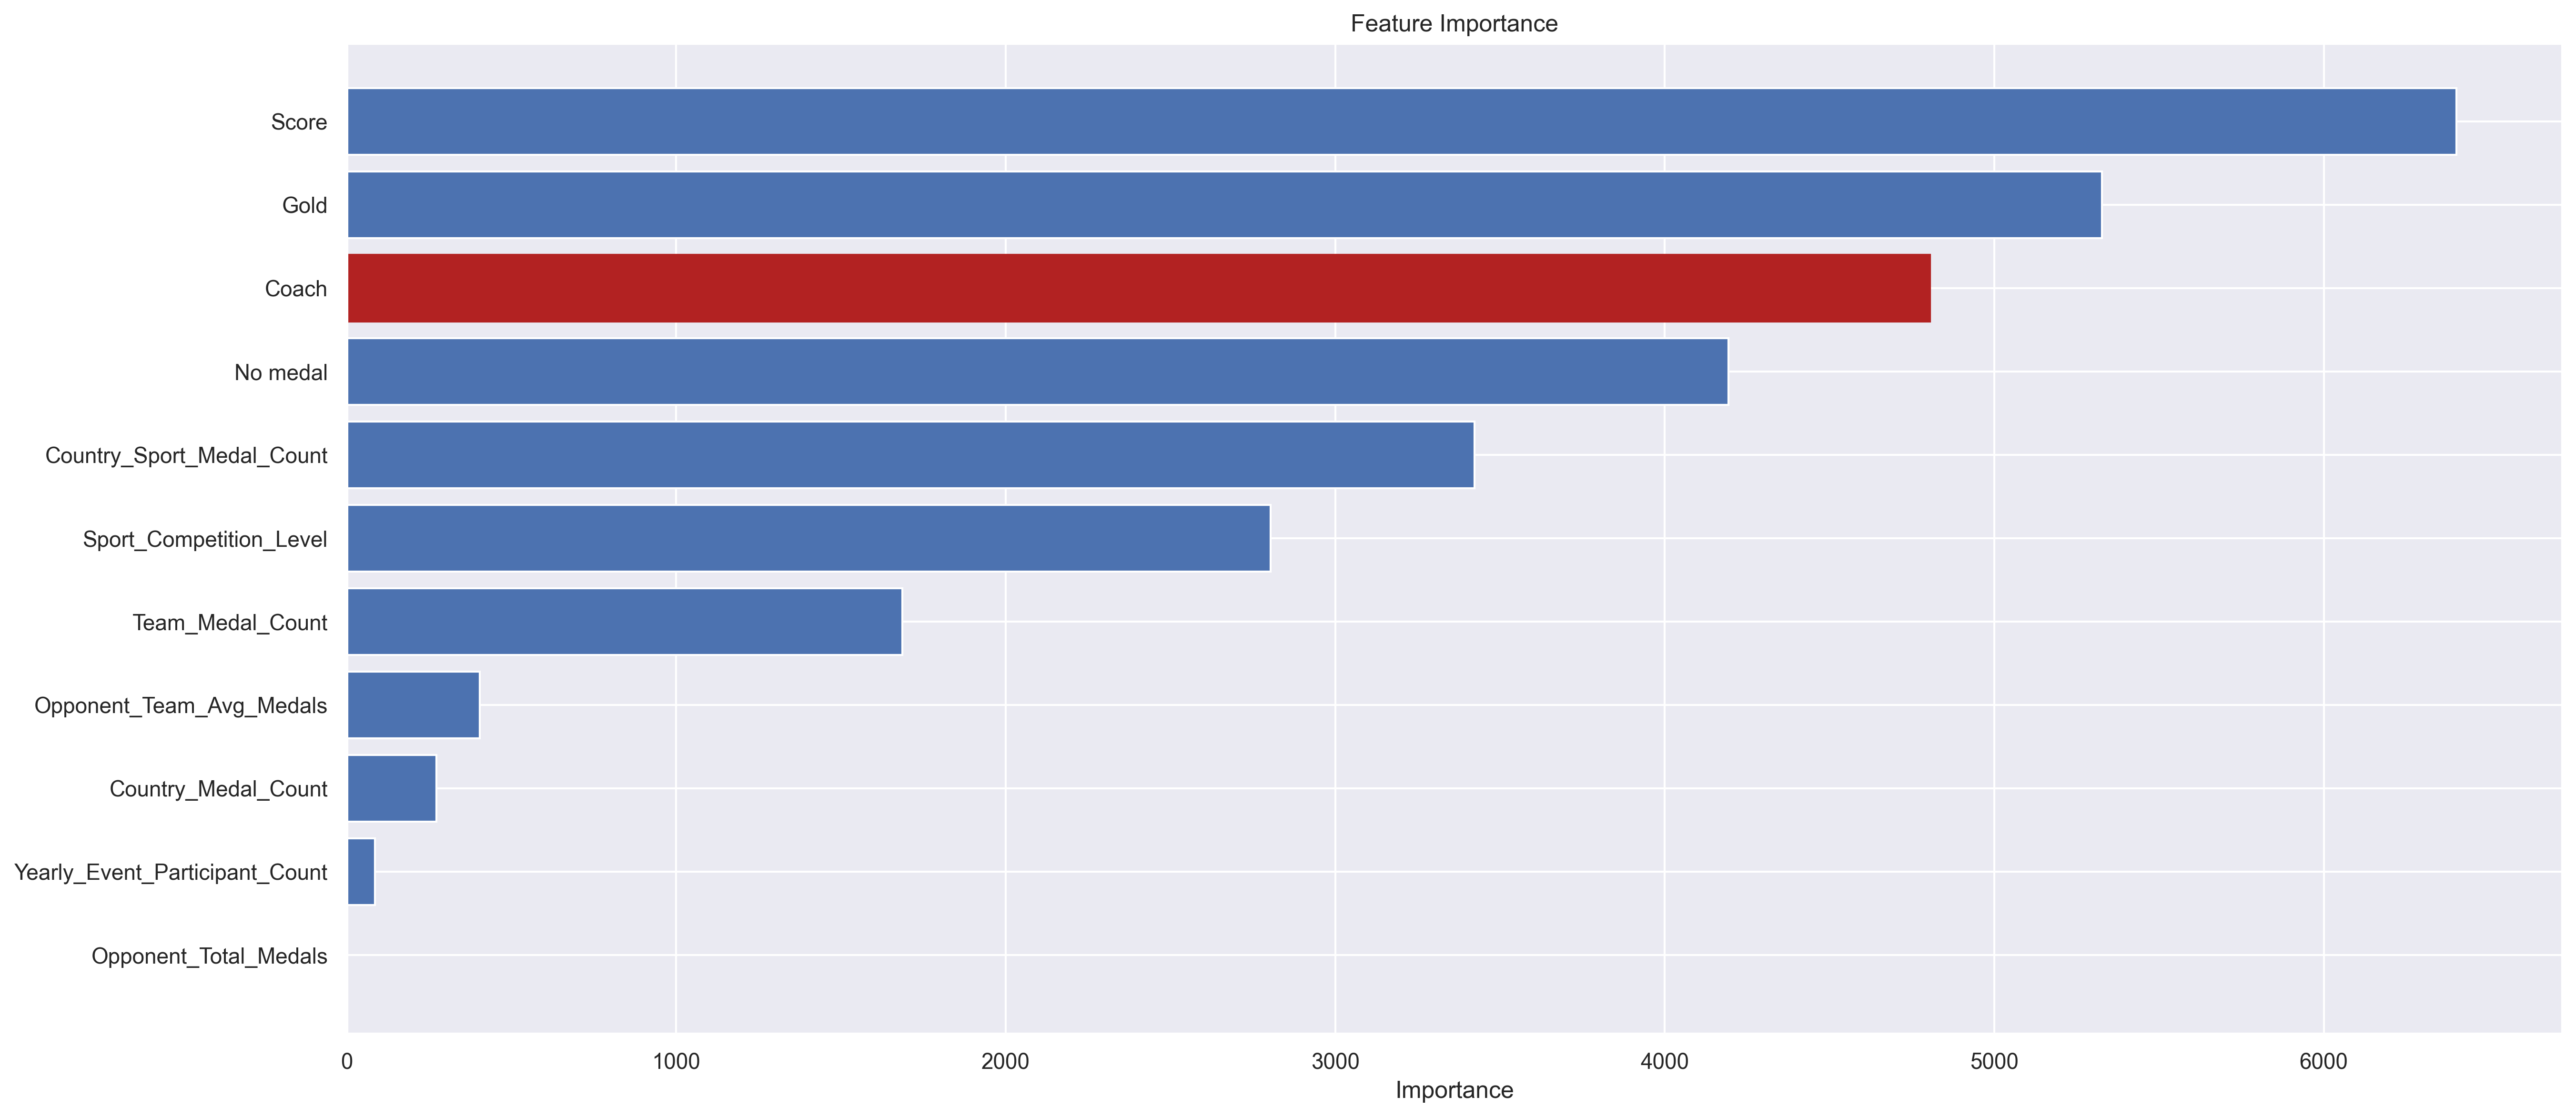

In [4]:
# 可视化特征重要性
plt.figure(figsize=(20, 9), dpi=300)
bars = plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
for bar, feature in zip(bars, feature_importance_df['Feature']):
    if feature == 'Coach':
        bar.set_color('firebrick')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis() 
plt.savefig('Cluster0 特征重要性.png')

## 三、Cluster1

In [5]:

## Cluster1
# 导入数据
data = pd.read_csv("cluster1.csv",index_col=0)
print(data.head())

X = data[features]
y = data[target]

## LightGBM
model = lgb.LGBMClassifier(learning_rate=0.1, min_child_samples=50, n_estimators=150, 
                               num_leaves=50, objective='multiclass', metric='multi_logloss', random_state=0)
model.fit(X, y)

# 获取特征重要性
importances = model.feature_importances_

# 打印特征重要性
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df

          Score  Team_Medal_Count  ...  Opponent_Total_Medals  Medal
编号                                 ...                              
1    968.352113              1140  ...                      0      0
2    419.945946              1140  ...                      0      0
49   761.953488              1736  ...                      0      0
84  1560.592593              1736  ...                      0      0
88   893.227273              1736  ...                      0      0

[5 rows x 12 columns]
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000770 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 812
[LightGBM] [Info] Number of data points in the train set: 46228, number of used features: 11
[LightGBM] [Info] Start training from score -0.273904
[LightGB

,Feature,Importance
5,Score,6293
6,Gold,5520
10,Coach,4709
4,No medal,3683
3,Country_Sport_Medal_Count,3516
7,Sport_Competition_Level,2946
1,Team_Medal_Count,1867
0,Opponent_Team_Avg_Medals,490
2,Country_Medal_Count,221
8,Yearly_Event_Participant_Count,78


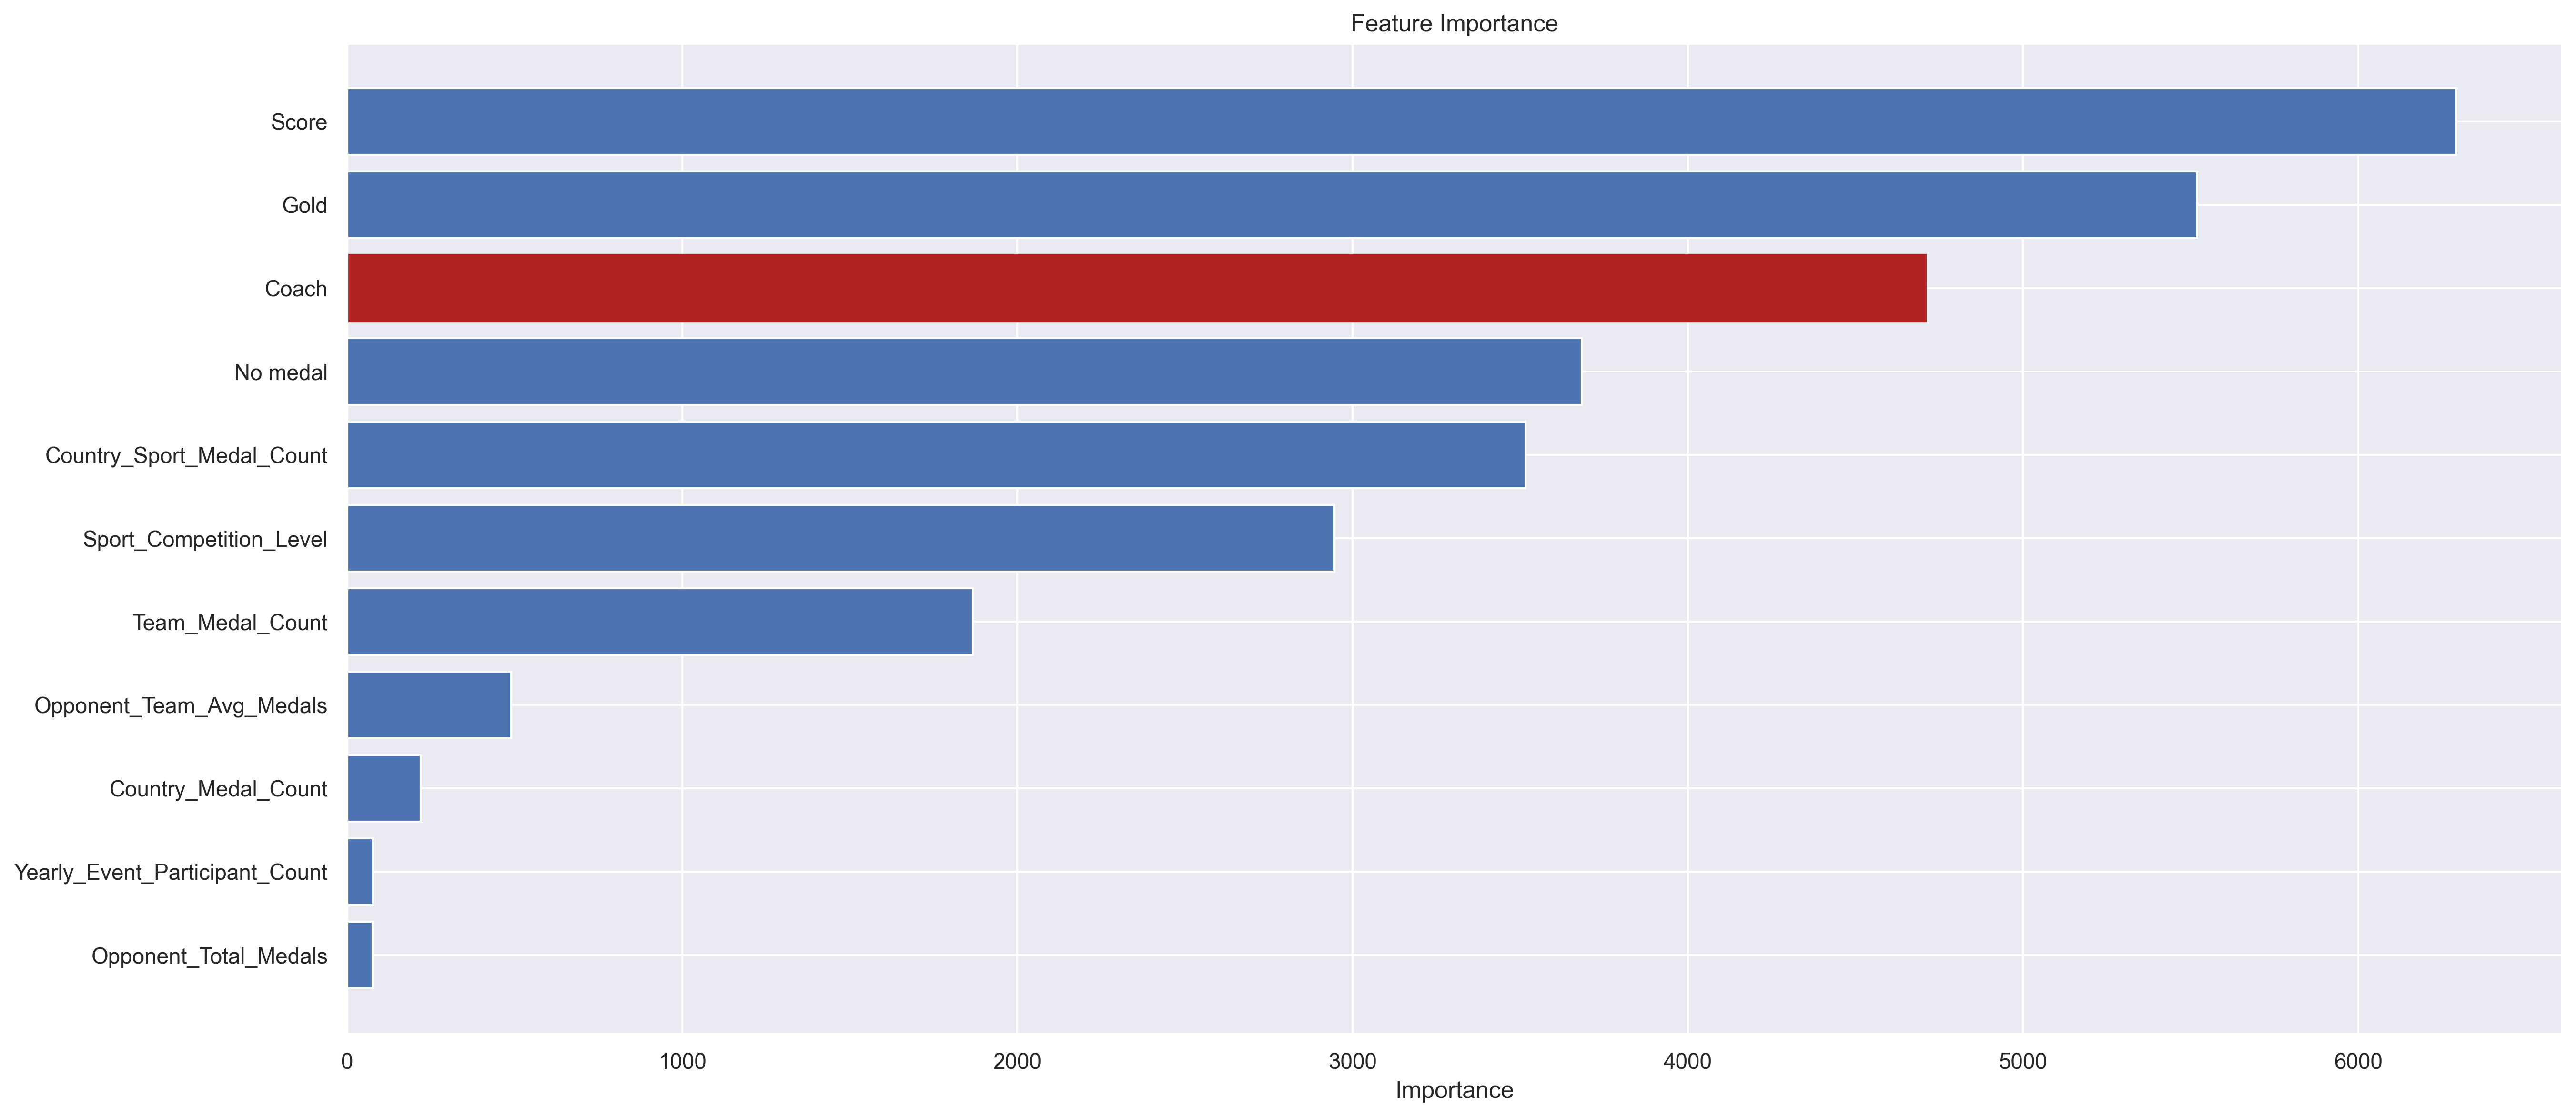

In [6]:
# 可视化特征重要性
plt.figure(figsize=(20, 9), dpi=300)
bars = plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
for bar, feature in zip(bars, feature_importance_df['Feature']):
    if feature == 'Coach':
        bar.set_color('firebrick')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis() 
plt.savefig('Cluster1 特征重要性.png')

## 四、Cluster2

In [7]:
## Cluster2
# 导入数据
data = pd.read_csv("cluster2.csv",index_col=0)
print(data.head())

X = data[features]
y = data[target]

## LightGBM
model = lgb.LGBMClassifier(learning_rate=0.1, min_child_samples=50, n_estimators=150, 
                               num_leaves=50, objective='multiclass', metric='multi_logloss', random_state=0)
model.fit(X, y)

# 获取特征重要性
importances = model.feature_importances_

# 打印特征重要性
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df

          Score  Team_Medal_Count  ...  Opponent_Total_Medals  Medal
编号                                 ...                              
7   1009.705882               452  ...                      0      0
8    734.485714               452  ...                      0      0
9    740.925926               452  ...                      0      0
10   796.137931               452  ...                      0      0
11  1198.916667               452  ...                      0      0

[5 rows x 12 columns]
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001227 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 794
[LightGBM] [Info] Number of data points in the train set: 75059, number of used features: 11
[LightGBM] [Info] Start training from score -0.120982
[LightGB

,Feature,Importance
5,Score,6673
6,Gold,5796
10,Coach,3942
4,No medal,3326
3,Country_Sport_Medal_Count,3220
1,Team_Medal_Count,2769
7,Sport_Competition_Level,2651
0,Opponent_Team_Avg_Medals,500
2,Country_Medal_Count,398
8,Yearly_Event_Participant_Count,89


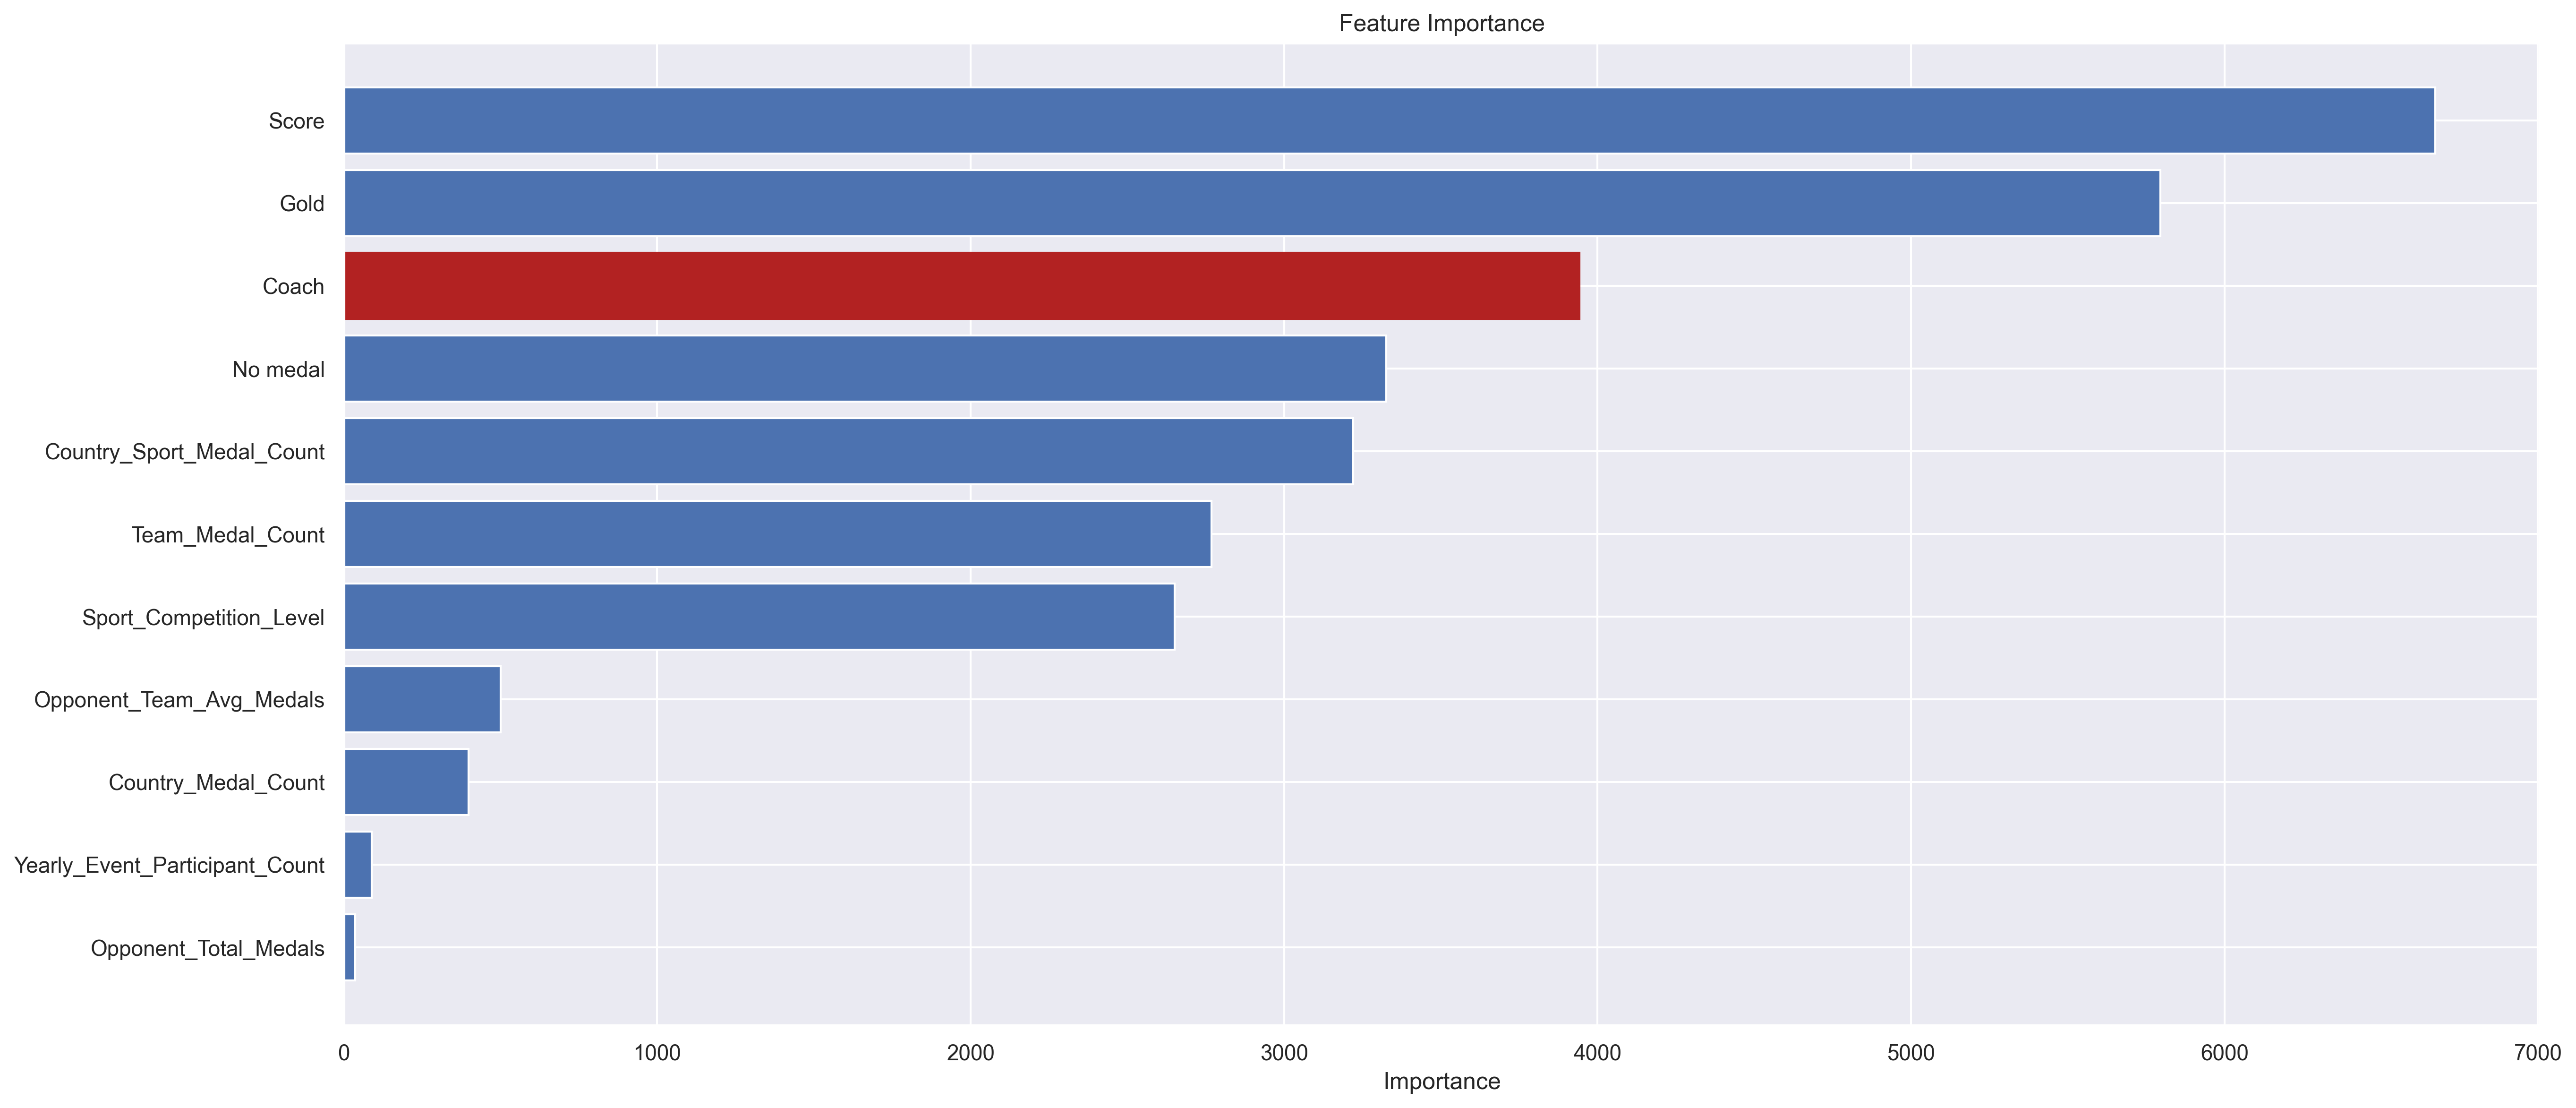

In [8]:

# 可视化特征重要性
plt.figure(figsize=(20, 9), dpi=300)
bars = plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
for bar, feature in zip(bars, feature_importance_df['Feature']):
    if feature == 'Coach':
        bar.set_color('firebrick')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis() 
plt.savefig('Cluster2 特征重要性.png')

## 五、Cluster3

In [9]:
## Cluster3
# 导入数据
data = pd.read_csv("cluster3.csv",index_col=0)
print(data.head())

X = data[features]
y = data[target]

## LightGBM
model = lgb.LGBMClassifier(learning_rate=0.1, min_child_samples=50, n_estimators=150, 
                               num_leaves=50, objective='multiclass', metric='multi_logloss', random_state=0)
model.fit(X, y)

# 获取特征重要性
importances = model.feature_importances_

# 打印特征重要性
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df

         Score  Team_Medal_Count  No medal  ...  Coach  Opponent_Total_Medals  Medal
编号                                          ...                                     
3   761.768421               622        71  ...     46                      0      0
4     8.000000                 6         9  ...     11                      0      3
34  869.380117               513        22  ...     41                      0      3
35  526.687500               681        16  ...      3                      0      0
36  682.250000               513        43  ...      3                      0      0

[5 rows x 12 columns]
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001161 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 811
[LightGBM] [Info] Number of data points in 

,Feature,Importance
5,Score,6059
6,Gold,5285
10,Coach,4407
4,No medal,3912
1,Team_Medal_Count,3160
3,Country_Sport_Medal_Count,2909
7,Sport_Competition_Level,2723
0,Opponent_Team_Avg_Medals,433
2,Country_Medal_Count,375
8,Yearly_Event_Participant_Count,81


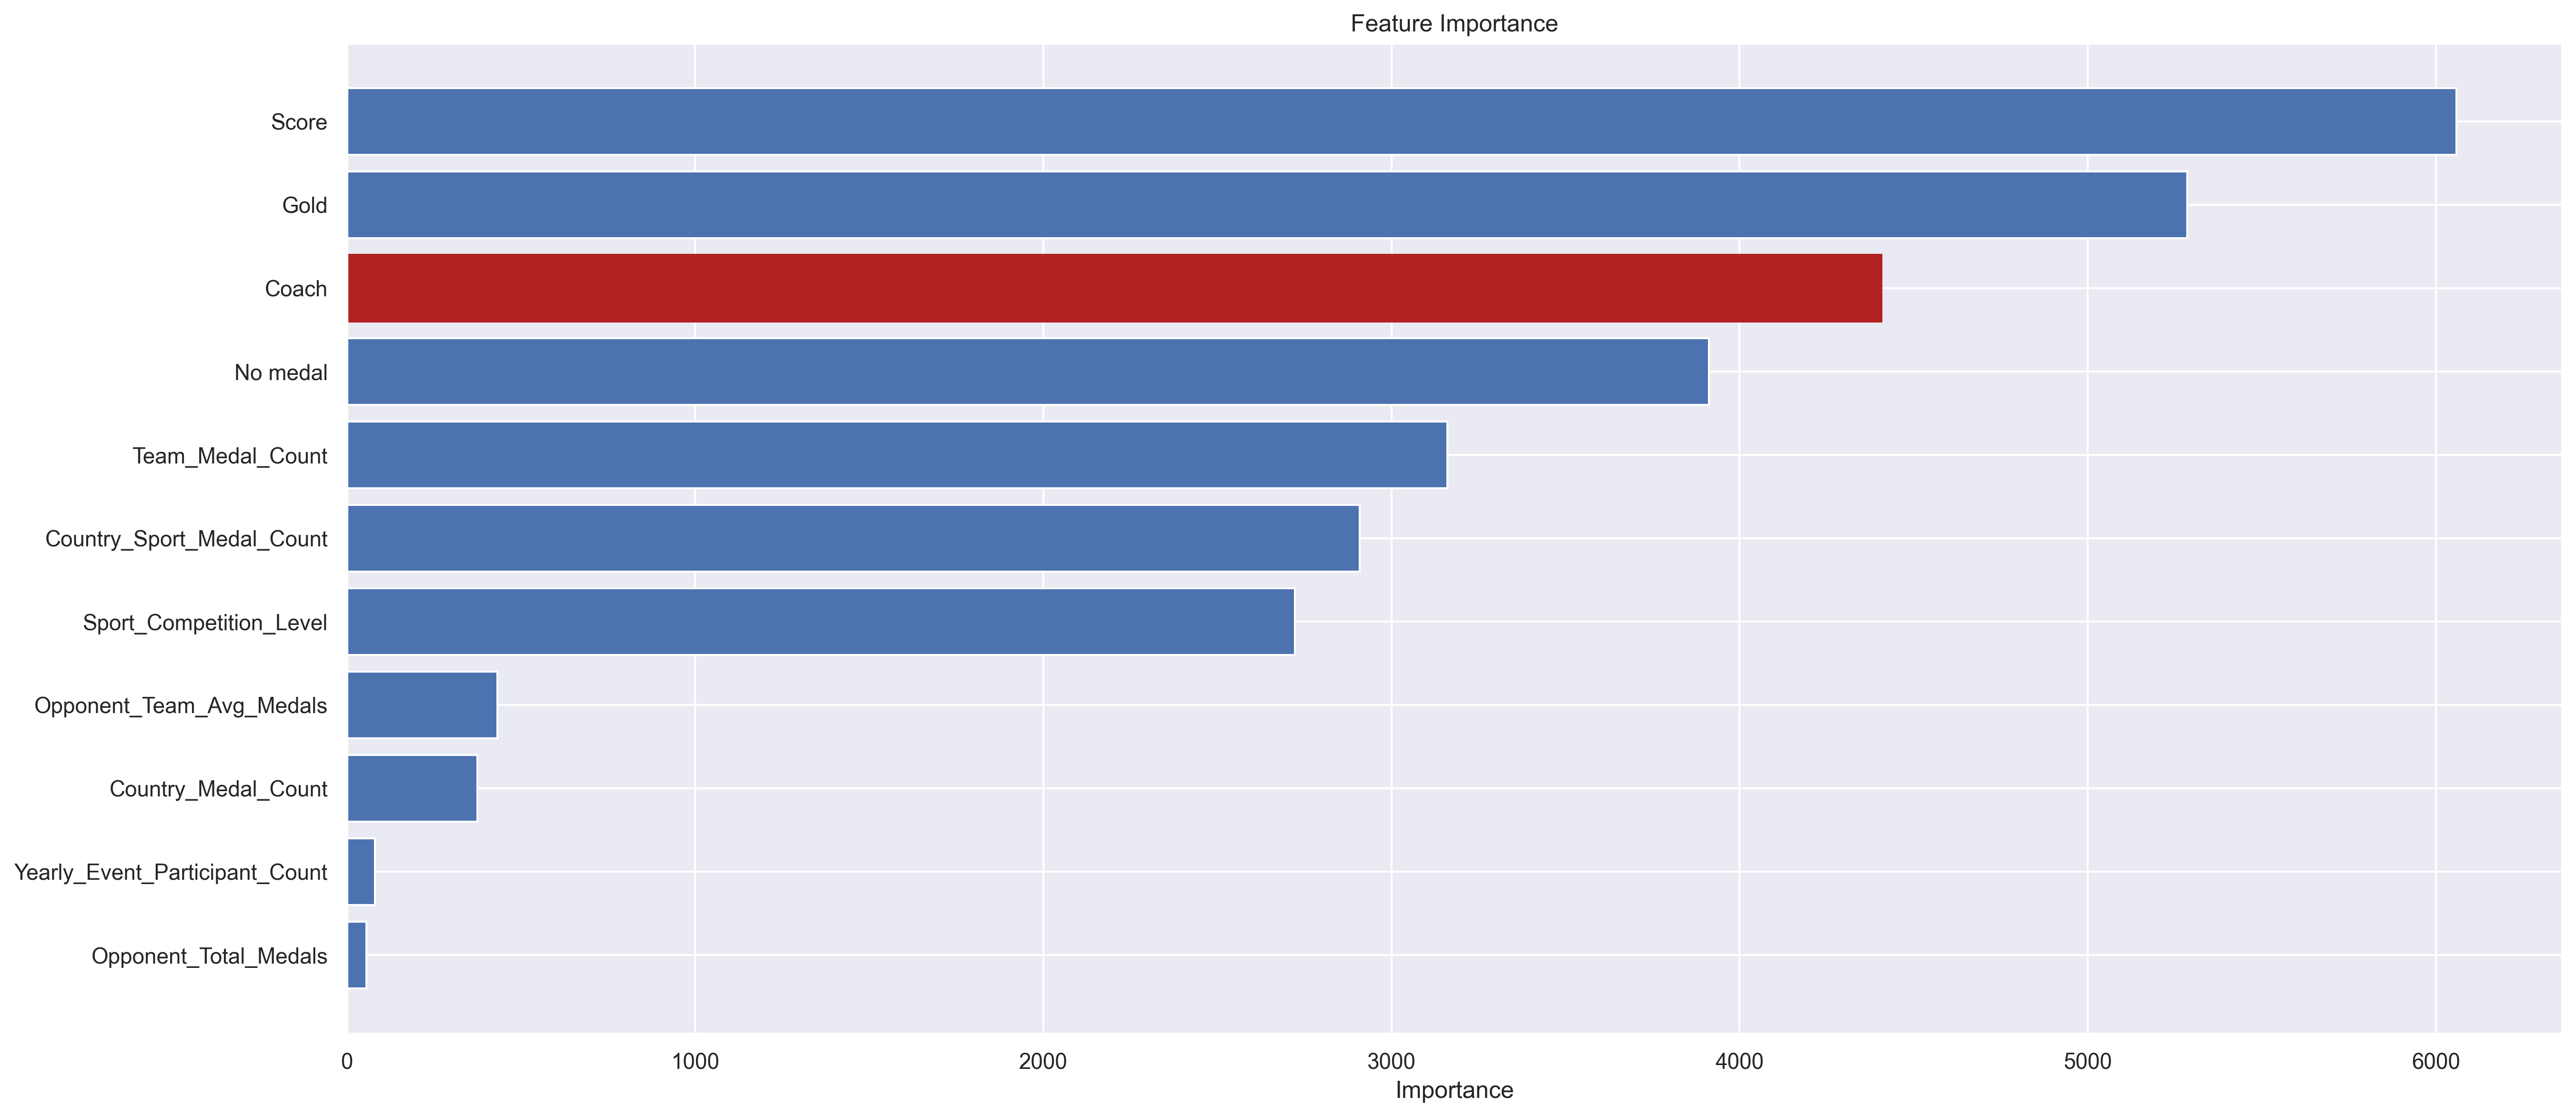

In [10]:
# 可视化特征重要性
plt.figure(figsize=(20, 9), dpi=300)
bars = plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
for bar, feature in zip(bars, feature_importance_df['Feature']):
    if feature == 'Coach':
        bar.set_color('firebrick')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis() 
plt.savefig('Cluster3 特征重要性.png')

## 六、全部结果合并

In [11]:
# 合并所有特征重要性图
fig, axs = plt.subplots(5, 1, figsize=(20, 45), dpi=300)
clusters = ['Data_all_Cluster', 'Cluster0', 'Cluster1', 'Cluster2', 'Cluster3']
for i, cluster in enumerate(clusters):
    data = pd.read_csv(f"{cluster}.csv", index_col=0)
    X = data[features]
    y = data[target]
    model.fit(X, y)
    importances = model.feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    bars = axs[i].barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
    for bar, feature in zip(bars, feature_importance_df['Feature']):
        if feature == 'Coach':
            bar.set_color('firebrick')
    axs[i].set_xlabel('Importance')
    axs[i].set_title(f'{cluster} Feature Importance')
    axs[i].invert_yaxis()
plt.tight_layout()
plt.savefig('Combined_Feature_Importance.png')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003075 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 988
[LightGBM] [Info] Number of data points in the train set: 252565, number of used features: 11
[LightGBM] [Info] Start training from score -0.166876
[LightGBM] [Info] Start training from score -2.961349
[LightGBM] [Info] Start training from score -2.986451
[LightGBM] [Info] Start training from score -2.966565
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000773 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 799
[LightGBM] [

**结果分析**不论是总从总体看还是从每一个Cluster看，最重要的是个人因素，其次是教练，最后是团队和对手  
**Coach因素所占比例自己算一下吧～**